In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
# 1. Data Preparation

# Load the datasets
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

In [37]:
# Merge necessary tables for prediction
data = orders.merge(order_reviews, on='order_id', how='left')
data = data.merge(order_items, on='order_id', how='left')
data = data.merge(products, on='product_id', how='left')
data = data.merge(customers, on='customer_id', how='left')
data = data.merge(order_payments, on='order_id', how='left')

# Basic data inspection
print(data.head())
print(data.info())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10

In [11]:
# Dropping columns not needed for prediction
data1.drop(['order_delivered_carrier_date','product_name_lenght','product_description_lenght', 'review_comment_title'], axis=1, inplace=True)

In [5]:
data1 = data.copy()
data1 = data1.dropna(subset=['product_id', 'review_id', 'product_height_cm', 'order_delivered_customer_date', 'product_category_name', 'order_approved_at', 'payment_installments'])

In [6]:
print(data1.isnull().sum())

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_customer_date        0
order_estimated_delivery_date        0
review_id                            0
review_score                         0
review_comment_message           59297
review_creation_date                 0
review_answer_timestamp              0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name                0
product_photos_qty                   0
product_weight_g                     0
product_length_cm                    0
product_height_cm                    0
product_width_cm                     0
customer_unique_id                   0
customer_zip_code_prefix 

In [7]:
# Encoding categorical variables
label_encoder = LabelEncoder()
data1['product_category_name'] = label_encoder.fit_transform(data1['product_category_name'].astype(str))
data1['review_score'] = label_encoder.fit_transform(data1['review_score'].astype(str))

In [8]:
# 2. Feature Selection & Engineering

# Creating new features
data1['total_payment'] = data1.groupby('order_id')['payment_value'].transform('sum')
data1['product_count'] = data1.groupby('order_id')['order_item_id'].transform('count')
data1['average_product_value'] = data1['total_payment'] / data1['product_count']

In [9]:
# Selecting the features for the model
features = ['product_category_name', 'payment_sequential', 'payment_type', 'payment_installments',
            'total_payment', 'product_count', 'average_product_value']
target = 'review_score'

X = data1[features]
y = data1[target]

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# 3. Model Building

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

In [11]:
# 4. Evaluation

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))





Accuracy: 56.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.38      0.43      3620
           1       0.40      0.28      0.33      1038
           2       0.30      0.22      0.25      2586
           3       0.35      0.29      0.32      5828
           4       0.66      0.76      0.70     17753

    accuracy                           0.57     30825
   macro avg       0.44      0.39      0.41     30825
weighted avg       0.54      0.57      0.55     30825



In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [13]:
# 3. Model Building


# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric="logloss")

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}")

/Users/francescocapo/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:31:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 60.31


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.14      0.23      3620
           1       0.76      0.06      0.11      1038
           2       0.83      0.05      0.09      2586
           3       0.74      0.05      0.09      5828
           4       0.60      0.99      0.75     17753

    accuracy                           0.60     30825
   macro avg       0.73      0.26      0.25     30825
weighted avg       0.66      0.60      0.49     30825



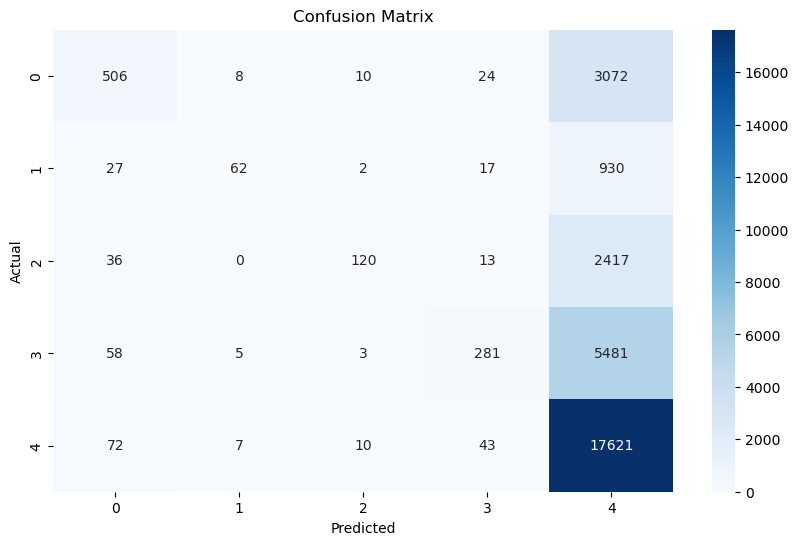

In [14]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


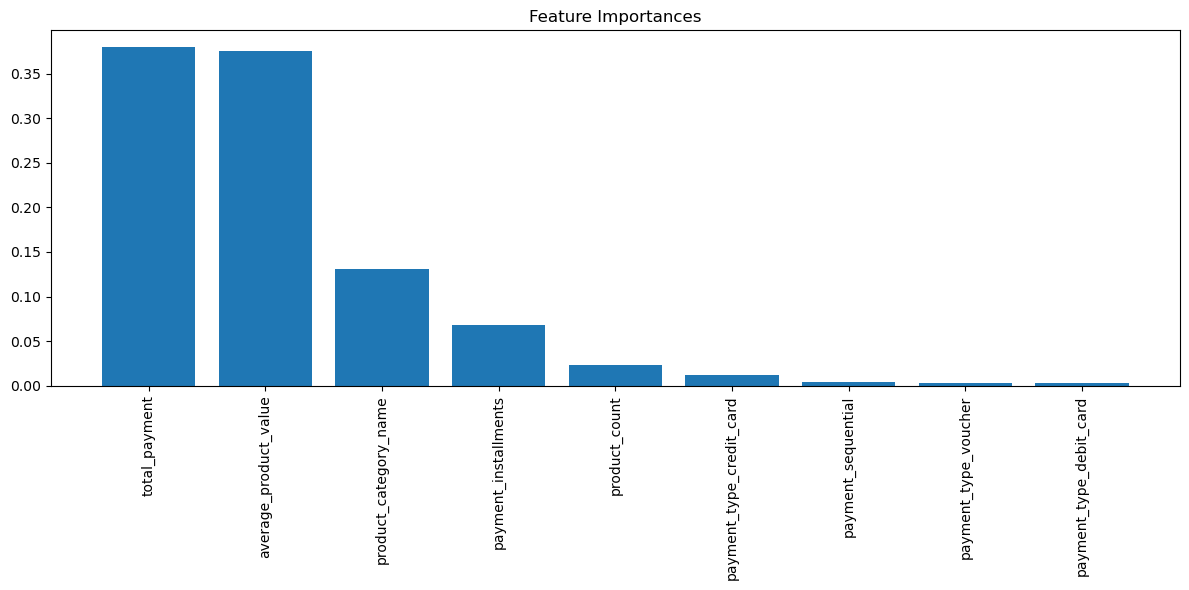

In [15]:
# Feature Importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
features_importance = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features_importance[indices], rotation=90)
plt.tight_layout()
plt.show()